In [5]:
#|default_exp training

In [6]:
#| export 
import pickle, gzip, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor, nn 
import torch.nn.functional as F 

In [7]:
from fastcore.test import test_close
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train),(x_valid, y_valid), _) = pickle.load(f, encoding='latin1')

In [8]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

#### initail setup
Data

In [9]:
n,m = x_train.shape
c = y_train.max() + 1
nh = 50

In [10]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [11]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [12]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [13]:
log_softmax(pred)

tensor([[-2.39, -2.24, -2.12,  ..., -2.27, -2.22, -2.53],
        [-2.41, -2.11, -2.21,  ..., -2.29, -2.34, -2.45],
        [-2.35, -2.34, -2.13,  ..., -2.22, -2.19, -2.48],
        ...,
        [-2.26, -2.25, -2.11,  ..., -2.32, -2.23, -2.45],
        [-2.33, -2.30, -2.11,  ..., -2.29, -2.31, -2.39],
        [-2.35, -2.36, -2.13,  ..., -2.22, -2.23, -2.46]], grad_fn=<LogBackward0>)

In [14]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [15]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [16]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [17]:
sm_pred = log_softmax(pred)

In [18]:
sm_pred

tensor([[-2.39, -2.24, -2.12,  ..., -2.27, -2.22, -2.53],
        [-2.41, -2.11, -2.21,  ..., -2.29, -2.34, -2.45],
        [-2.35, -2.34, -2.13,  ..., -2.22, -2.19, -2.48],
        ...,
        [-2.26, -2.25, -2.11,  ..., -2.32, -2.23, -2.45],
        [-2.33, -2.30, -2.11,  ..., -2.29, -2.31, -2.39],
        [-2.35, -2.36, -2.13,  ..., -2.22, -2.23, -2.46]], grad_fn=<SubBackward0>)

In [19]:
#|export 
def accuracy(out, yb):
    return (out.argmax(dim=1) == yb).float().mean()

In [20]:
#|export 
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [21]:
m = nn.Module()
#
# 
m.foo = nn.Linear(3,4)
m.act = nn.ReLU()
m

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
  (act): ReLU()
)

In [22]:
list(m.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True)), ('act', ReLU())]

In [23]:
ml = nn.ModuleList([nn.Linear(3,4), nn.ReLU()])

In [24]:
ml

ModuleList(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): ReLU()
)

In [25]:
list(ml.parameters())

[Parameter containing:
 tensor([[-0.23, -0.32, -0.45],
         [ 0.23, -0.49, -0.41],
         [ 0.05, -0.01, -0.32],
         [-0.36,  0.10,  0.24]], requires_grad=True),
 Parameter containing:
 tensor([ 0.21, -0.51, -0.12, -0.56], requires_grad=True)]

In [26]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [27]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [28]:
model = MLP(m, nh, 10)

In [29]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [30]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [31]:
for name, l in model.named_children():
    print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [32]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [33]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [34]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
loss_func = F.cross_entropy

In [35]:
opt = Optimizer(model.parameters())

In [36]:
from itertools import islice

In [37]:
epochs = 3
bs = 50
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)
        

0.12, 0.98
0.04, 1.00
0.03, 1.00


In [38]:
from torch import optim

In [39]:
lr = 0.5
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(),lr=lr)

In [40]:
s = slice(0,50)
model , opt = get_model()
loss = loss_func(model(x_train[s]), y_train[s])

In [41]:
loss

tensor(2.29, grad_fn=<NllLossBackward0>)

In [42]:
#|export 
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

In [43]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [44]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds 
        self.bs = bs
    def __iter__(self):
        for i in range(0, len(self.ds),self.bs): yield self.ds[i:i+self.bs]

In [45]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [46]:
xb, yb = next(iter(train_dl))
xb.shape

torch.Size([50, 784])

In [47]:
def fit():
    model, opt = get_model()
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [48]:
fit()

0.19, 0.94
0.13, 0.92
0.16, 0.92


### Random Sampling

In [49]:
import random


In [50]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [51]:
from itertools import islice

In [52]:
ss = Sampler(train_ds)

In [53]:
it = iter(ss)
for o in range(5):
    print(next(it))

0
1
2
3
4


In [54]:
list(islice(ss,7))

[0, 1, 2, 3, 4, 5, 6]

In [55]:
ss = Sampler(train_ds, shuffle=True)

In [56]:
list(islice(ss,5))

[3309, 1193, 24811, 38587, 25344]

In [57]:
import fastcore.all as fc

In [58]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [59]:
batches = BatchSampler(ss,7)
list(islice(batches, 10))

[[12949, 37021, 40078, 37986, 25820, 48690, 44851],
 [9750, 38898, 38808, 1045, 41209, 27777, 25765],
 [25248, 29588, 48195, 30441, 44165, 31737, 36551],
 [16452, 41770, 31735, 30775, 25824, 18769, 40575],
 [25029, 24493, 3407, 15891, 29667, 16460, 22317],
 [28064, 28296, 21686, 34090, 14059, 35923, 44003],
 [16631, 1011, 9737, 39814, 11033, 24289, 24917],
 [7316, 38127, 38694, 24529, 8669, 17297, 13558],
 [34112, 31585, 4748, 6575, 14313, 8708, 27719],
 [33869, 35194, 41, 8652, 8994, 23981, 12708]]

In [60]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [61]:
class DataLoader():
    def __init__(self, ds, batches, collate_fn= collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batches)

In [62]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [63]:
train_dl = DataLoader(train_ds,batches=train_samp)
valid_dl = DataLoader(valid_ds, batches=valid_samp)

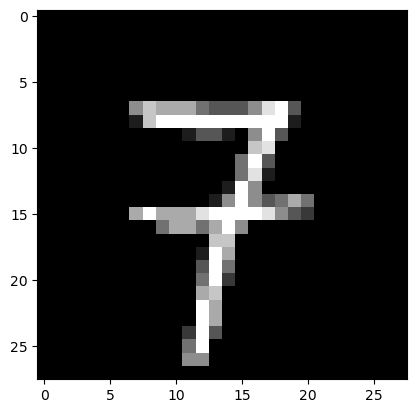

In [64]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))

In [65]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

### Multiiprocessing in dataloader

In [66]:
import torch.multiprocessing as mp 
from fastcore.basics import store_attr

In [67]:
train_ds[[3,6,8, 1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [68]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [69]:
for o in map(train_ds.__getitem__,([3,6],[8,1])): print (o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [70]:
class DataLoader():
    def __init__(self, ds, batches, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex:
            yield from ex.map(self.ds.__getitem__, iter(self.batches))

### pytorch dataloader

In [71]:
#|export 
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler, RandomSampler

In [72]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [73]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [74]:
fit()

0.41, 0.90
0.01, 1.00
0.03, 1.00


> pytorch can auto generate the batch sampler

In [75]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [76]:
# or this can be done using the shuffle 
train_dl = DataLoader(train_ds, bs, shuffle=True, collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs,shuffle=False, collate_fn=collate)

In [77]:
fit()

0.09, 0.94
0.07, 0.96
0.03, 1.00


In [78]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.,0., 0
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count +=n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        print(epoch, tot_loss/ count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [79]:
#|export 
def get_dls(train_ds, valid_ds, bs, **kwarg):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwarg),
            DataLoader(valid_ds, batch_size=bs, shuffle=False, **kwarg))

In [80]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model=model, loss_func=loss_func, opt=opt, train_dl=train_dl, valid_dl=valid_dl)

0 0.15082009656820447 0.9536999994516373
1 0.13534947886597365 0.9602999997138977
2 0.11357427586830454 0.9674000003933907
3 0.10747459832200548 0.9704000002145767
4 0.10799022649851395 0.9704999986290932


In [81]:
import nbdev; nbdev.nbdev_export()

/opt/miniconda3/envs/DL/lib/python3.10/site-packages/nbdev/export.py:54: UserWarning: Notebook '/Volumes/Others/Fastai course/miniai/nbs/05_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
